In [311]:
import sys
sys.path.append('..')

In [320]:
import pixiedust
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from pyquaternion import Quaternion 
from Utilities import *

%matplotlib inline
np.random.seed=1

In [321]:
path1 = '../datasets/10hz.csv'
dataset = pd.read_csv(path1)
length, width = dataset.shape

limit = length

In [322]:
X, y = getXyVelocityModel(dataset, limit=limit, frequency=10.0)
train = int(0.9 * limit)
xTrain, xTest, yTrain, yTest = X[:train], X[train:], y[:train], y[train:] 

In [323]:
y.head()

,dXB,dYB,dZB,dRoll,dPitch,dYaw
0,3.411711e-08,-2.547820e-10,-0.259528,-1.935395e-15,1.394288e-07,5.979928e-09
1,4.009054e-08,-2.473373e-10,-0.907338,-2.105352e-15,-2.269107e-08,7.448762e-09
2,4.331183e-08,-2.548621e-10,-1.601208,-2.053661e-15,-2.269113e-08,1.102308e-08
3,4.614643e-08,-2.548833e-10,-2.249746,-1.992826e-15,-2.269113e-08,1.250328e-08
4,4.983913e-08,-2.549464e-10,-2.860831,-1.915269e-15,-2.269113e-08,1.519993e-08


## Sanity Check (Acceleration)

In [346]:
plot_limit = 500
frequency = 10.0

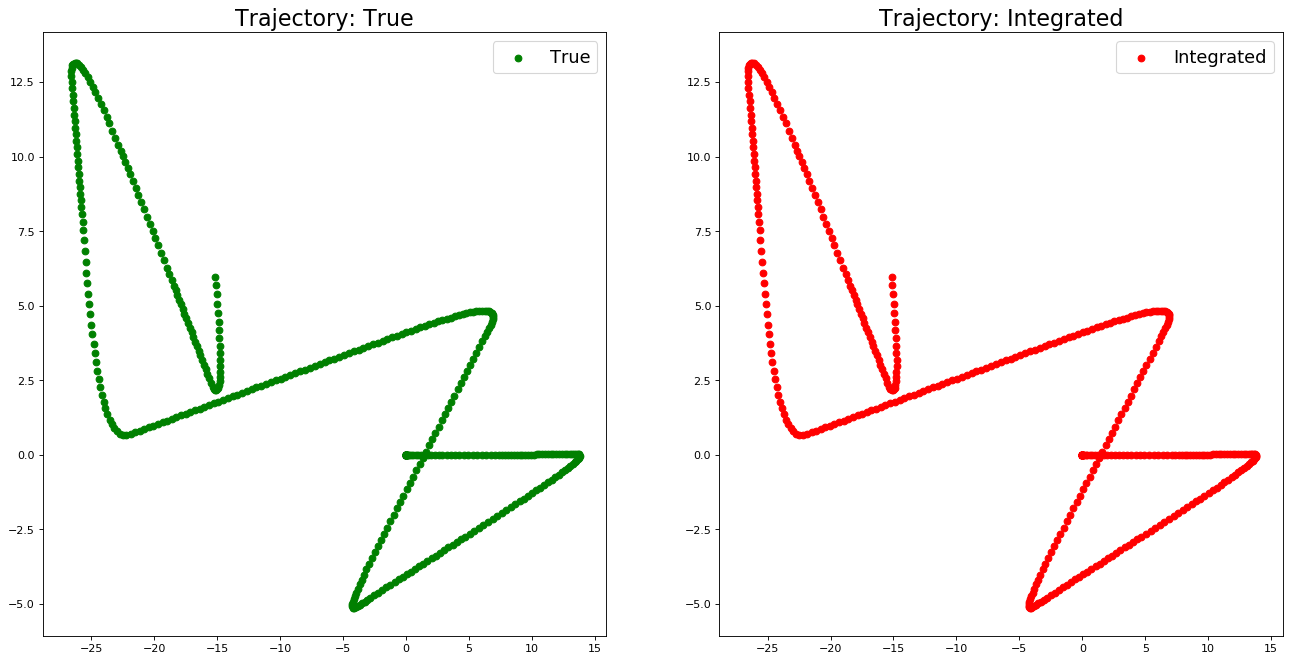

In [357]:
gen2 = integrateTrajectoryVelocityBody(position=dataset.loc[0, ['x', 'y', 'z']].values,
                                       orientation=Quaternion(dataset.loc[0, ['scalar', 'i', 'j', 'k']].values),
                                       linearVelocities=y[['dXB', 'dYB', 'dZB']].values,
                                       angularVelocities=y[['dRoll', 'dPitch', 'dYaw']].values,
                                       frequency=frequency * np.ones((plot_limit, )))

plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

for i in range(1, plot_limit):
    # ------------------
    plt.subplot(1, 2, 1)
    plt.legend(['True'], fontsize=16)
    plt.title('Trajectory: True', fontdict={'fontsize':20})
    
    pTrue = dataset.loc[i, ['x', 'y', 'z']]
    oTrue = dataset.loc[i, ['roll', 'pitch', 'yaw']]
    plt.scatter(pTrue[0], pTrue[1], color='green')
    
    # -----------------
    plt.subplot(1, 2, 2)
    plt.legend(['Integrated'], fontsize=16)
    plt.title('Trajectory: Integrated', fontdict={'fontsize':20})
    
    o, p, _, _ = next(gen2)
    plt.scatter(p[0], p[1], color='red') 
    
    try:
        assert(np.allclose(p.astype(np.float64), pTrue.astype(np.float64)))
    except:
        print('Unit test failed! at: {} after {} seconds'.format(i, int(i/frequency)))
        break

# Acceleration Prediction Models

### MLP Regressor (one step)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

cvModel = MLPRegressor(max_iter=int(10e3), random_state=10)
parameters = {'hidden_layer_sizes':[(80, )], 'alpha':[1e-6 * np.exp(i) for i in range(5)]}
clf = GridSearchCV(cvModel, parameters, n_jobs=-1).fit(xTrain, yTrain)

mlp_cv = MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                      alpha=clf.best_params_['alpha'], 
                      max_iter=int(10e8), 
                      random_state=10).fit(xTrain, yTrain)

In [ ]:
yPredicted = pd.DataFrame(mlp_cv.predict(xTest), columns=y.columns)

print('MLP RMSE on test dataset:\n---')

for i in y.columns:
    print(i + '\t', mean_squared_error(yPredicted[i], yTest[i]) ** 0.5)
    
mlp = MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                   alpha=clf.best_params_['alpha'], max_iter=int(10e8), random_state=10).fit(X, y)

### Random Forest (one step)

In [409]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

randomForest = RandomForestRegressor(max_depth=25, random_state=10).fit(xTrain, yTrain)

In [411]:
yPredicted2 = pd.DataFrame(randomForest.predict(xTest), columns=y.columns)
print('Random Forest RMSE on test dataset per second:\n---')

for i, c in enumerate(y.columns):
    error = (mean_squared_error(yPredicted2[c], yTest[c]) ** 0.5)
    print(c + '\t', np.rad2deg(error) if i > 2 else error)

Random Forest RMSE on test dataset per second:
---
dXB	 0.0499590239934
dYB	 0.0463391664861
dZB	 0.0218537439235
dRoll	 2.97694571419
dPitch	 4.43907870698
dYaw	 2.42860286322


In [360]:
def integrateTrajectoryVelocityBody(position, orientation, linearVelocities, angularVelocities, frequency):
    for v, w, f in zip(linearVelocities, angularVelocities, frequency):
        eulerRates = transformBodyRatesToEarth(w, orientation)
        linearVelocityEarth = transformToEarthFrame(v, orientation)
        
        newOrientation = integrateOrientation(orientation, eulerRates, f)
        position = integratePosition(position, linearVelocityEarth ,f)
        
        yield (newOrientation,
               position,
               transformToBodyFrame(linearVelocityEarth, newOrientation),
               transformEulerRatesToBody(eulerRates, newOrientation))
        
        orientation = newOrientation

In [366]:
def predict(actions, position, orientation, x0, frequency=10, limit=100, model=mlp_cv):
    linearVelocity = x0[[0, 1, 2]]
    angularVelocity = x0[[3, 4, 5]]
    
    for i in range(0, limit):
        if i > 0:
            s0 = np.concatenate((linearVelocity, angularVelocity, toEulerianAngle(orientation)[[0, 1]], actions[i]))
        else:
            s0 = x0
            
        s1 = model.predict(s0.reshape(1, -1))[0]
        
        orientation, position, linearVelocity, angularVelocity=\
        next(integrateTrajectoryVelocityBody(position=position,
                                             orientation=orientation,
                                             linearVelocities=[s0[[0, 1, 2]]],
                                             angularVelocities=[s0[[3, 4, 5]]],
                                             frequency=[frequency]))
        yield orientation, position

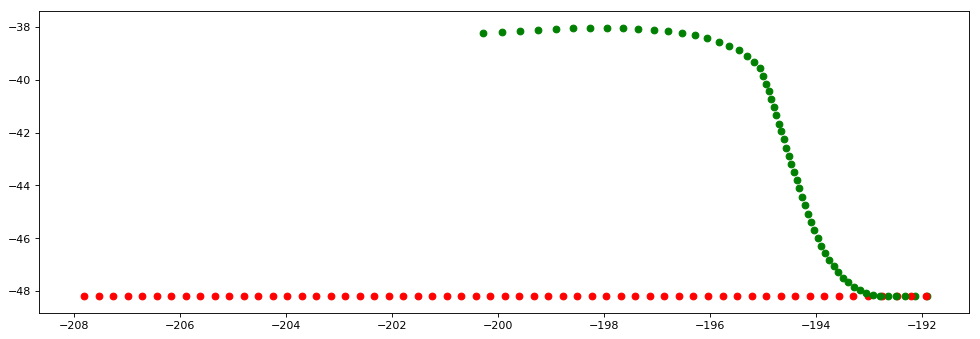

In [397]:
plt.figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

limit = 60
shift = np.random.randint(xTest.shape[0]-limit)

actions = xTest[['moveForward', 'yawCCW', 'yawCW', 'hover']].values[shift:]
position = dataset.loc[train + shift, ['x', 'y', 'z']].values
orientation = Quaternion(dataset.loc[train + shift, ['scalar', 'i', 'j', 'k']].values)

gen2 = predict(position=position, orientation=orientation, x0=xTest.iloc[shift].values, actions=actions)

for i in range(1, limit):
    pTrue = dataset.loc[i+train+shift, ['x', 'y', 'z']]
    o, p = next(gen2)

    plt.scatter(pTrue[0], pTrue[1], color='green')
    plt.scatter(p[0], p[1], color='red')